In [1]:
import pynbody
import numpy as np

In [38]:
def make_batches(n_parts, n_batches): 
    batch_size = n_parts/n_batches
    curr_start = 0
    while curr_start < n_parts:
        yield((curr_start, min(curr_start+batch_size, n_parts+1)))
        curr_start += batch_size

In [103]:
from pyspark.sql import Row
from pynbody import util, units, family
from pyspark.sql.types import ArrayType, DoubleType, FloatType, NullType
class SparkTipsySnap(pynbody.tipsy.TipsySnap) :
    
    def _load_main_file(self):
        logger.info("Loading data from main file %s", self._filename)

        f = util.open_(self._filename, 'rb')
        f.seek(32)

        max_item_size = max(
            [q.itemsize for q in self._g_dtype, self._d_dtype, self._s_dtype])
        tbuf = bytearray(max_item_size * 10240)

        for fam, dtype in ((family.gas, self._g_dtype), (family.dm, self._d_dtype), (family.star, self._s_dtype)):
            self_fam = self[fam]
            st_len = dtype.itemsize
            for readlen, buf_index, mem_index in self._load_control.iterate([fam], [fam], multiskip=True):
                # Read in the block
                if mem_index is None:
                    f.seek(st_len * readlen, 1)
                    continue

                buf = np.fromstring(f.read(st_len * readlen), dtype=dtype)
                
                if self._byteswap:
                    buf = buf.byteswap()
                
                yield buf, buf_index, fam
                
    
fam_lookup = {family.dm:'d', family.gas: 'g', family.star:'s'}

def buf_to_row(buf, buf_index, names, fam) : 
    if type(buf_index) == slice:
        buf_index = xrange(buf_index.start, buf_index.stop)
    for i in buf_index :
        d = {name:float(buf[name][i]) for name in buf.dtype.names}
        for name in names: 
            if name not in d: 
                d[name] = np.nan
                d['fam'] = fam_lookup[fam]
        yield Row(**d)                

In [4]:
def load_partition(filename, batch_iter, names) : 
    for batch in batch_iter :
        s = SparkTipsySnap(filename, take = xrange(*batch))
        loader = s._load_main_file()
        for buf, bi, fam in loader : 
            for row in buf_to_row(buf, bi, names, fam) : 
                yield row

In [5]:
filename = '/Users/rok/python_src/pynbody/nose/testdata/g15784.lr.01024'
s = pynbody.load(filename)

In [6]:
names = set(s._g_dtype.names) | set(s._s_dtype.names) | set(s._d_dtype.names)

In [7]:
n_parts = len(s)
batch_size = 1000

In [47]:
batches = make_batches(n_parts,sc.defaultParallelism*20)

In [48]:
batches_rdd = sc.parallelize(batches, 40)

In [50]:
sim_rdd = batches_rdd.mapPartitions(lambda iterator: load_partition(filename, iterator, names))

In [51]:
sim_rdd.first()

Row(eps=9.125000360654667e-06, fam='g', mass=3.193105849175204e-11, metals=2.317891366480408e-16, phi=0.032422397285699844, rho=0.011995542794466019, temp=59857.33203125, tform=nan, vx=0.016735026612877846, vy=-0.015475508756935596, vz=-0.16838803887367249, x=0.010709313675761223, y=-0.036197926849126816, z=-0.16635996103286743)

In [52]:
df = sim_rdd.toDF().cache()

In [53]:
df.select(df.mass, df.eps, df.rho, df.fam).filter(df['fam'] == 'g').describe().show()

+-------+--------------------+--------------------+-------------------+
|summary|                mass|                 eps|                rho|
+-------+--------------------+--------------------+-------------------+
|  count|              158755|              158755|             158755|
|   mean|3.151274578483528...|9.125000360654667E-6|  7746.708507373103|
| stddev|2.829688592054584...|7.909205638009592...| 143304.14060095474|
|    min|1.129416178635711...|9.125000360654667E-6|7.70558381191222E-6|
|    max|7.962470266464905...|9.125000360654667E-6|          9257588.0|
+-------+--------------------+--------------------+-------------------+



In [54]:
df.write.mode('overwrite').parquet('/Users/rok/Projects/pynbody_spark/g15784.lr.01024.parquet')

In [55]:
sqc = SQLContext(sc)

In [56]:
df2 = sqc.read.parquet('/Users/rok/Projects/pynbody_spark/g15784.lr.01024.parquet')

In [57]:
df2.count()

1717156

In [58]:
df2.printSchema()

root
 |-- eps: double (nullable = true)
 |-- fam: string (nullable = true)
 |-- mass: double (nullable = true)
 |-- metals: double (nullable = true)
 |-- phi: double (nullable = true)
 |-- rho: double (nullable = true)
 |-- temp: double (nullable = true)
 |-- tform: double (nullable = true)
 |-- vx: double (nullable = true)
 |-- vy: double (nullable = true)
 |-- vz: double (nullable = true)
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)
 |-- z: double (nullable = true)



In [88]:
sampled = df2.select('x','y').sample(False, 0.1, 1).toPandas()

In [99]:
import matplotlib.pylab as plt

In [101]:
%matplotlib inline

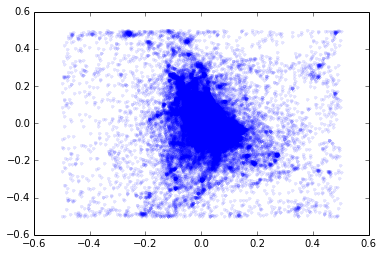

In [102]:
plt.plot(sampled['x'], sampled['y'], '.', alpha = .1)